In [ ]:
import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import glob
import PIL
import imageio

from IPython import display

In [ ]:
from tensorflow.keras.datasets import mnist

(X_train, _), (X_test, _) = mnist.load_data()

In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
X_train[0].shape

(28, 28)

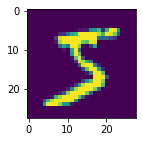

In [ ]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(X_train[0])
plt.show()

<Figure size 144x216 with 0 Axes>

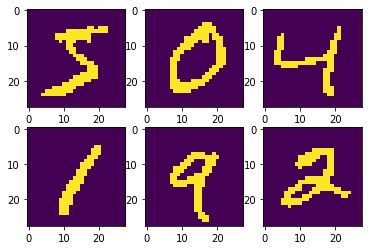

In [ ]:
fig = plt.figure(figsize=(2, 3))
f, axarr = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        axarr[i, j].imshow(X_train[i*3+j])
plt.show()

In [ ]:
X_train = np.expand_dims(X_train, axis=3).astype(np.float32)
X_test = np.expand_dims(X_test, axis=3).astype(np.float32)

In [ ]:
X_train = X_train / 255.
X_test = X_test / 255.

In [ ]:
X_train[X_train >= .5] = 1.
X_train[X_train < .5] = 0.
X_test[X_test >= .5] = 1.
X_test[X_test < .5] = 0.

In [ ]:
len_train = 60000
len_test = 10000
batch_size = 32

X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(len_train).batch(batch_size)
X_test = tf.data.Dataset.from_tensor_slices(X_test).shuffle(len_test).batch(batch_size)

In [ ]:
from tensorflow.keras import layers

class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        inputs = layers.Input(shape=(28, 28, 1))
        x = layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu")(inputs)
        x = layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu")(x)
        x = layers.Flatten()(x)
        outputs = layers.Dense(latent_dim + latent_dim)(x)
        self.inference_net = tf.keras.models.Model(inputs=inputs, outputs=outputs)

        inputs = layers.Input(shape=(latent_dim,))
        x = layers.Dense(7*7*32, activation='relu')(inputs)
        x = layers.Reshape(target_shape=(7, 7, 32))(x)
        x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu')(x)
        x = layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2,2), padding='same', activation='relu')(x)
        outputs = layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1,1), padding='same')(x)
        self.generative_net = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [ ]:
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 100
latent_dim = 50
model = CVAE(latent_dim)

In [ ]:
num_examples_to_generate = 16
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in X_train:
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()

    if epoch % 1 == 0:
        
        loss = tf.keras.metrics.Mean()
        for test_x in X_test:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
              'time elapse for current epoch {}'.format(epoch,
                                                        elbo,
                                                        end_time - start_time))
        
        generate_and_save_images(model, epoch, random_vector_for_generation)

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('/content/image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

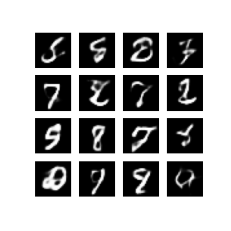

In [ ]:
plt.imshow(display_image(50))
plt.axis('off')

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
    display.Image(filename=anim_file)